In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
NB_LABEL = 10

In [4]:
def weight_variable(shape):
    stddev = np.sqrt(1. / np.prod(shape[:-1]))
    print(stddev)
    initial = tf.random_normal(shape, stddev = stddev)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0., shape=shape)
    return tf.Variable(initial)

In [5]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


In [6]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, NB_LABEL])

In [7]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

0.2


In [8]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [9]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [10]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

0.0353553390593


In [11]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

0.0178571428571


In [12]:
#keep_prob = tf.placeholder(tf.float32)
#h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### mu, sigma encoder

In [13]:
W_mu = weight_variable([1024, 4])
b_mu = bias_variable([4])
mu_encoder = tf.matmul(h_fc1, W_mu) + b_mu

W_logvar = weight_variable([1024, 4])
b_logvar = bias_variable([4])
logvar_encoder = tf.matmul(h_fc1, W_logvar) + b_logvar



0.03125
0.03125


In [14]:
# Sample epsilon
epsilon = tf.random_normal(tf.shape(logvar_encoder), name='epsilon')

# Sample latent variable
std_encoder = tf.exp(0.5 * logvar_encoder)
z = mu_encoder + tf.multiply(std_encoder, epsilon)

### Decoder

In [15]:
'''W_fc2 = weight_variable([32, 10])
b_fc2 = bias_variable([10])'''

W_fc2 = weight_variable([4, 32])
b_fc2 = bias_variable([32])

h_decoder = tf.nn.relu(tf.matmul(z, W_fc2) + b_fc2)
W_fc3 = weight_variable([32, 10])
b_fc3 = bias_variable([10])

y_logit = tf.matmul(h_decoder, W_fc3) + b_fc3

0.5
0.176776695297


In [16]:
indices = tf.argmax(y_logit, 1)
depth = NB_LABEL
y_hat = tf.one_hot(indices, depth)

In [61]:
correct_prediction = tf.cast(tf.equal(tf.argmax(y_logit, 1), tf.argmax(y_, 1)), tf.float32)
reward = correct_prediction - (1 - correct_prediction)
reward_KL = 1 #correct_prediction

In [68]:
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

## !! reduce_sum pour le calcul de KL (reward a l'exterieur)
rewarded_KL = tf.reduce_mean(-0.5  * reward_KL * tf.reduce_sum((1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder)), reduction_indices=1))

# !! reduce_mean (reward à l'interieur)
#rewarded_cross_entropy = reward * tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=y_hat, logits=y_logit), reduction_indices=1)
rewarded_cross_entropy =   tf.reduce_mean(reward * tf.nn.softmax_cross_entropy_with_logits(labels=y_hat, logits=y_logit))

rewarded_loss = rewarded_KL + 30 * rewarded_cross_entropy


train_step = tf.train.AdamOptimizer(1e-4).minimize(rewarded_loss)
accuracy = tf.reduce_mean(correct_prediction)



In [69]:
sess = tf.InteractiveSession()

In [70]:
sess.run(tf.global_variables_initializer())

In [71]:
for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1]}) #, keep_prob: 1.0})
        code_loss = np.mean(rewarded_KL.eval(feed_dict={x: batch[0], y_: batch[1]})) #, keep_prob: 1.0})
        reco_loss = np.mean(rewarded_cross_entropy.eval(feed_dict={x: batch[0], y_: batch[1]})) #, keep_prob: 1.})
        print('step %d, training accuracy %g, code_loss %g, reconstr_loss %g' % (i, train_accuracy, code_loss, reco_loss))
    train_step.run(feed_dict={x: batch[0], y_: batch[1]}) #, keep_prob: 0.5})

   

step 0, training accuracy 0.08, code_loss 0.17748, reconstr_loss -1.15574
step 100, training accuracy 0.36, code_loss 3.22064, reconstr_loss -0.549863
step 200, training accuracy 0.42, code_loss 4.12214, reconstr_loss -0.590794
step 300, training accuracy 0.44, code_loss 4.91161, reconstr_loss -0.807821
step 400, training accuracy 0.52, code_loss 5.90305, reconstr_loss -0.735171
step 500, training accuracy 0.66, code_loss 8.56605, reconstr_loss -0.445734
step 600, training accuracy 0.64, code_loss 7.29398, reconstr_loss -0.383121
step 700, training accuracy 0.64, code_loss 7.69601, reconstr_loss -0.578245
step 800, training accuracy 0.6, code_loss 6.7497, reconstr_loss -0.561375
step 900, training accuracy 0.56, code_loss 7.19564, reconstr_loss -0.683824
step 1000, training accuracy 0.64, code_loss 6.90499, reconstr_loss -0.516239
step 1100, training accuracy 0.58, code_loss 7.04758, reconstr_loss -0.847877
step 1200, training accuracy 0.56, code_loss 7.01745, reconstr_loss -0.499317


KeyboardInterrupt: 

In [58]:
print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))


test accuracy 0.9601


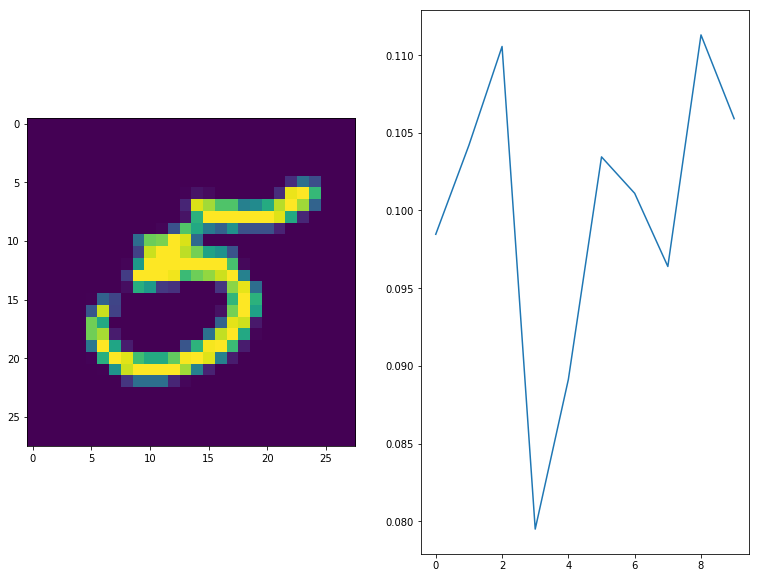

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
code = sess.run(tf.nn.softmax(y_logit), feed_dict={x: batch[0], y_: batch[1]})
#pred = sess.run(x_gen, feed_dict={x: batch[0], y_: batch[1]})
i = 6
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.reshape(batch[0][i],(28, 28)))
plt.subplot(1,3,2)
plt.plot(code[i])
#plt.subplot(1,3,3)
#plt.imshow(np.reshape(pred[i],(28, 28)))



In [ ]:
reward.eval(feed_dict={x: batch[0], y_: batch[1]}) 

In [ ]:
sess.run((reward, -0.5 * reward * tf.reduce_sum((1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder)), reduction_indices=1)),
        feed_dict={x: batch[0], y_: batch[1]})